In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

%matplotlib inline

import pingouin as pg
import warnings
warnings.filterwarnings("ignore")

sns.set()

## <font color='red'>Ada Boost (Adaptive Boosting)</font>
 
There are 3 main concepts behind AdaBoost:

1. In a Random Forest, each time you make a tree, you make a FULL-SIZED tree (no predetermined max depth). In a Forest of Trees made with AdaBoost, the trees are usually just A NODE AND TWO LEAVES! These are called STUMPS (Forest of Stumps). Stumps are technically weak learners.
2. In a Random Forest, each tree has an equal vote on the final classification. In contrast, in a Forest of Stumps made with AdaBoost, some stumps get more say in the final classification!
3. Lastly, in a Random Forest, each decision tree is made independently of the others. In contrast, in a Forest of Stumps made with AdaBoost, ORDER is important: the errors that the first stump makes influence how the second stump is made, and . so on.

See: https://www.youtube.com/watch?v=LsK-xG1cLYA

#### Creating a Forest of Stumps with AdaBoost

- Step 1: First, give each sample a WEIGHT, that indicates how important it is to be correctly classified. At the start, all samples get the same weight: 1/number_of_samples. However, after we make the first stump, these weights will change!
- Step 2: Make the first STUMP in the forest. For this, we check which feature makes the best classifier by comparing the GINI INDEX for all possible stumps. (remember: in the context of decision trees, the GINI IMPURITY is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset).
- Step 3: Based on how well the stump has performed, we determine its weight in the final forest. The TOTAL ERROR = sum of weights of incorrectly classified samples:
$$\text{Amount of Say} = \frac{1}{2}\log\left(\frac{1- \text{Total Error}}{\text{Total Error}} \right)~.$$
Note that if Amount of Say is a very Large Negative value, then the negative of the stump is a very good stump!
- Step 4: Increase SAMPLE WEIGHTS for incorrectly classified samples using:
$$ \text{New sample weight} = \text{old weight} \times e^{\text{Amount of Say}}~,$$
and decrease the weights of correctly classified samples using:
$$ \text{New sample weight} = \text{old weight} \times e^{-\text{Amount of Say}}~,$$
and finally normalize the new sample weights.
- Step 5: Make new STUMP in forest using the new sample weights. This can be done by evaluating the WEIGHTED GINI INDEX for all possible stumps. Alternatively, one can create a new dataset (of same size as original sample) by duplicating the samples with larger sample weights and reapeating then Steps 2-5.

#### Classifications using AdaBoost

- Consider a dataset and imagine that we have already built a Forest of Stumps using the above prescription. Then, given a new sample, we run it through every stump in the forest, and split the stumps into two categories, depending on the outcome. We then compute the TOTAL AMOUNT OF SAY for each group of stumps, which will give the output for the new sample.

### An Example:

see https://machinelearningmastery.com/adaboost-ensemble-in-python/

- Boosting is a class of ensemble machine learning algorithms that involve combining the predictions from many weak learners. AdaBoost (adaptive boosting) algorithm was the first successful approach for the idea. Each subsequent model attempts to correct the predictions made by the model before it in the sequence. This is achieved by weighing the training dataset to put more focus on training examples on which prior models made prediction errors.

AdaBoost is provided via the AdaBoostRegressor and AdaBoostClassifier classes. We will use the make_classification() function to create a synthetic binary classification problem with 1000 examples and 20 input features.

We will evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

In [1]:
from sklearn.datasets import make_classification

# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


In [5]:
model = AdaBoostClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.806 (0.041)


- Similarly, for regression tasks, we have the following procedure:

In [12]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=6)
model = AdaBoostRegressor()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -73.053 (4.062)


### AdaBoost Parameters

- n_estimators: set by default to 50. Each stump is a weak learner, so need a large number of stumps (could vary from 10 to 5000).
- base_estimator: one can change the weak learners to be more skillful. For instance, one can use DecisionTreeClassifier(), with certain max_depth, as the base_estimator. The base model can be also chosen as LOGISTIC REGRESSION etc.
- learning_rate (default set to 1.0): this controls the contribution of each model to the ensemble prediction. Sometimes, very small values such as 0.1, 0.01 or 0.001 can be used to avoid overfitting.


AdaBoost can be challenging to configure as the algorithm as many key hyperparameters that influence the behavior of the model on training data and the hyperparameters interact with each other. As such, it is a good practice to use a search process to discover a configuration of the model hyperparameters that works well or best for a given predictive modeling problem. Popular search processes include a random search and a GRID SEARCH.

In [13]:
from sklearn.model_selection import GridSearchCV


X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)

model = AdaBoostClassifier()

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
grid_result = grid_search.fit(X, y)

In [14]:
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.813667 using {'learning_rate': 0.1, 'n_estimators': 500}
0.646333 (0.036376) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.646667 (0.036545) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.646667 (0.036545) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.647000 (0.038136) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.646667 (0.036545) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.647000 (0.038136) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.654333 (0.045511) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.672667 (0.046543) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.648333 (0.042197) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.671667 (0.045613) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.715000 (0.053213) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.767667 (0.045948) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.716667 (0.048876) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.767000

### Data Preparation for AdaBoost
This section lists some heuristics for best preparing your data for AdaBoost.

1. Quality Data: Because the ensemble method continues to attempt to correct misclassifications in the training data, you need to be careful that the training data is of a high-quality.
2. Outliers: Outliers will force the ensemble down the rabbit hole of working hard to correct for cases that are unrealistic. These could be removed from the training dataset.
3. Noisy Data: Noisy data, specifically noise in the output variable can be problematic. If possible, attempt to isolate and clean these from your training dataset.

## <font color='red'>Gradient Boosting</font>

### <font color='green'>Gradient Boost for Regression</font>

Note: Gradient Boost for Regression is DIFFERENT from doing Linear Regression.

- Recall: AdaBoost starts by building Stumps from training data and assigning an amount of say. The next stumps are built from the errors of the previous stump.
- In contrast, GRADIENT BOOST starts by making a SINGLE LEAF instead of a tree or stump. This Leaf represents an initial guess for the y_pred value of all the samples. For a continuous RV y, the first guess is typically the average value. 
- Then, Gradient BOOST builds a tree. Like AdaBoost, this tree is based on the errors of the previous tree, but this tree is usually larger than a stump, unlike in AdaBoost. The max number of leaves is, however, still restricted (in practice, between 8 and 32).
- Like AdaBoost, Gradient Boost scales the trees, but unlike AdaBoost, all trees are scaled by the SAME AMOUNT!

- See: https://www.youtube.com/watch?v=2xudPOBz-vs

#### Building Gradient Boosted forests

- Step 1: First prediction is the average y value(i.e. the first tree is a single leaf!). Compute errors for this first tree as $Y - \bar{Y}$. (These are also called PSEUDO RESIDUALS)
- Step 2: Build a tree using all features where the predicted variable will be the above RESIDUALS, rather than y itself. If multiple residuals go to the same leaf, replace the leaf value with their average in the tree. To make a NEW PREDICTION of the y value, we combine the original prediction (which was just $\bar{Y}$) with the new tree prediction (which is a residual).
- Note that, to avoid overfitting, gradient boost uses a LEARNING RATE ($\in[0,1]$) to scale the contribution from the new tree. This leads to SMALL STEPS in the right direction, which, empirically, lead to better Predictions! (e.g. If learning rate was 1, a leaf with only ONE residual would then lead to a perfect prediction as $\bar{Y} + residual = Y$.):
$$ Y_1 = \bar{Y} + \nu \times residual~.$$
- Step 3: Then, we repeat this process. We compute the new residuals $Y - Y_1$ and build a new tree for these residuals, leading to new predictions $Y_2$:
$$ Y_2 = \bar{Y} + \nu \times \left( residual_1 + residual_2 \right)~.$$
- The process repeats until we get to the specified maximum number of tress, or until new trees do not improve the accuracy any longer.
- NOTE: ALL trees are scaled by THE SAME LEARNING RATE!

#### Regression details.


- Consider data $\{(x_i,y_i)\}$ with a differentiable LOSS FUNCTION $L(y_i, F(x))$, where $\gamma = F(x)$ are the predicted values. For regression, the most common loss function is the MSE function:
$$L(y_i, F(x)) = \frac{1}{2}(y_i - \gamma_i)^2~. $$
Note also that its first order derivative is:
$$\frac{dL}{d\hat{y}_i} = -(y_i - \gamma_i)~,$$
which we refer to as the NEGATIVE RESIDUAL. NOTE that if we were to use a different loss function, we wouldn't get the usual residuals, and would refer to them instead as PSEUDO-RESIDUALS. Now, recall the above steps:
- Step 1: Initialize model with a constant value $\gamma$:
$$ F_0(x) = {\rm argmin}_{\gamma}\sum_{i=1}^n L(y_i, \gamma)~.$$
Here, the ${\rm argmin}_{\gamma}$ means that we need to find a predicted value $\gamma$ that minimizes this sum. This is just a minimization problem: we take the derivative wrt $\gamma$ of the sum and set it equal to 0, which gives:
$$ \gamma = \bar{y}~,$$
as claimed before! This is the leaf of the first 'tree', which gives just the average value for any $y_i$.


Step 2: this is now a loop where we make all the trees $m = 1, \ldots, M$, for some fixed $M$. 

- For all $i = 1, \ldots, n$, compute the residuals as the derivative (i.e. GRADIENT) of the loss function (as seen before):
$$ r_{i,m} = - \left(\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right)_{F(x) = F_{m-1}(x)}~.$$
- Fit a Regression Tree to the $r_{i,m}$ values to create 'terminal regions' (i.e. LEAVES of the trees) $R_{j,m}$, for $j = 1, \ldots, J_m$. These contain possibly multiple $y$ values that are assigned by the tree(s) to the same leaf $j$. 
- Now, for each leaf in the new tree(s), as multiple $y$ values can end up in the 'terminal region' $R_{j,m}$, it is ambiguous what output value $\gamma_{j,m}$ to assign. Hence, for each $j = 1, \ldots, J_m$, compute:
$$\gamma_{j,m} = {\rm argmin}_{\gamma} \sum_{x_i \in R_{i,j}} L(y_i, F_{m-1}(x_i) + \gamma)~,$$
where we are now taking the previous prediction into account. Note that the summation only includes the values $x_i$ in the SAME terminal region. For the MSE loss function used above, we find:
$$\gamma_{j,m} = {\rm argmin}_{\gamma} \sum_{x_i \in R_{i,j}} \left(y_i - F_{m-1}(x_i) - \gamma)\right)^2~,$$
whose derivative becomes:
$$\gamma_{j,m} = \sum_{y_i \in R_{j,m}} \frac{1}{N_{j,m}}(y_i - F_{m-1}(x_i)) ~,$$
i.e. the average of the residuals ending up in the same leaf!
- Next, update $$F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_m}\gamma_{j,m}\, I(x\in R_{j,m})~.$$
The summation says that we add up the Output values $\gamma_{j,m}$ for all the leaves $R_{j,m}$ in the $m$th three for which there are samples $x$ found in. Here, $\nu$ is the LEARNING RATE!

Step 3:
- Output F_M(x). This can be used to predict new values.

#### Iterating through the process

See: https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502
and: https://github.com/tomonori-masui/gradient-boosting/blob/main/gradient_boosting_regression.ipynb

- Gradient boosting is powerful enough to find any nonlinear relationship between your model target and features and has great usability that can deal with missing values, outliers, and high cardinality categorical values on your features without any special treatment. While you can build barebone gradient boosting trees using some popular libraries such as XGBoost or LightGBM without knowing any details of the algorithm, you still want to know how it works when you start tuning hyper-parameters, customizing the loss functions, etc., to get better quality on your model.
- Gradient boosting is one of the variants of ensemble methods where you create multiple weak models and combine them to get better performance as a whole.

- Let us first generate some data with only ONE feature, which, however, is NOT linear!

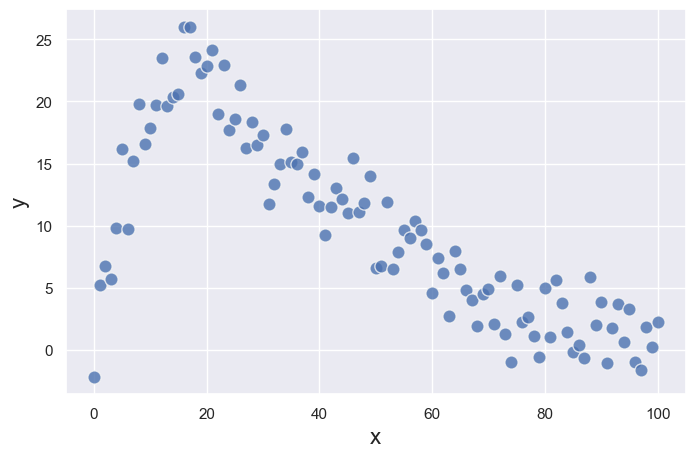

In [32]:
import scipy.stats as stats

np.random.seed(123)
x = np.linspace(0, 100, 101)
# generating y using gamma distribution
y = (stats.gamma.pdf(x, a=2, loc=0, scale=17) + np.random.normal(0,0.002,101)) * 1000
x = x.reshape(-1,1)

plt.rcParams["figure.figsize"] = (8, 5)
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()


- The first step in the Gradient Boosting algorithm is to make a prediction which is just the average value:

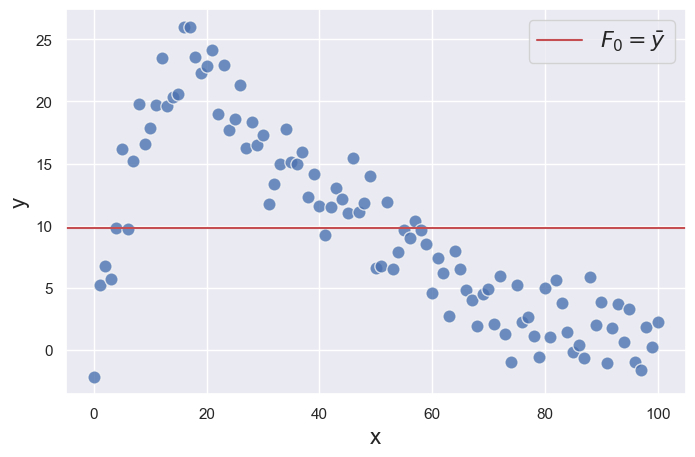

In [7]:
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.axhline(y=y.mean(), color='r', linestyle='-', label=r'$F_{0} = \bar{y}$')

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=16)
plt.show()

- Next up, we compute the residuals from the first step $r_1$, and plot them below (the vertical blue lines)

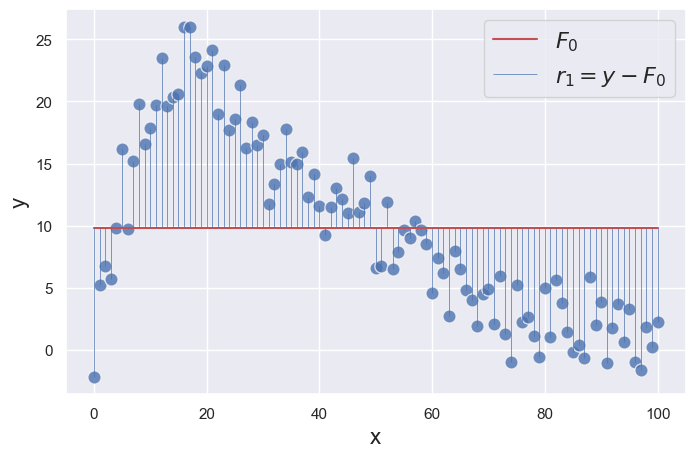

In [9]:
def plot_residuals(x, y, Fm, i, ax, title = ""):
    
    fltr_smaller = y < Fm
    fltr_bigger = y >= Fm

    ax.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    ax.plot(x, Fm, c='r', label=f'$F_{i}$')
    
    # add vertical lines
    ax.vlines(x[fltr_smaller], y[fltr_smaller], Fm[fltr_smaller], linewidth=0.5, color='b', label=f'$r_{i+1} = y - F_{i}$')
    ax.vlines(x[fltr_bigger], Fm[fltr_bigger], y[fltr_bigger], linewidth=0.5, color='b')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.legend(fontsize=16)
    
fig, ax = plt.subplots(1, 1)
F0 = np.full(len(y), y.mean())
plot_residuals(x, y, F0, 0, ax)
plt.show()

- We want to build a tree with x as the only feature ar the residuals as the target. For simplicity, let's say the the first tree is a STUMP

In [10]:
# this function print out tree structures. adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def print_tree(clf):
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print('-'*80)
    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node.".format(
                    space=node_depth[i] * "\t", node=i
                )
            )
            print(node_depth[i] * '\t', f"prediction: {clf.tree_.value[i, 0, 0]:.1f}")
        else:
            print(
                "{space}node={node} is a split node: "
                "go to node {left} if X[:, {feature}] <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature[i],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )
    print('-'*80)

In [11]:
def train_and_update(x, y, Fm, learing_rate=0.1):
    
    r = y - Fm
    tree = DecisionTreeRegressor(max_depth=1, random_state=0)
    tree.fit(x, r)
    gamma = tree.predict(x)
    Fm = Fm + learing_rate * gamma
    
    return tree, Fm, gamma, r


def plot_gamma(x, residuals, gamma, i, ax, title = ""):
    
    ax.scatter(x, residuals, edgecolors='whitesmoke', color = 'g', s=90, alpha=0.8, label=f'$r_{i} = y – F_{i-1}$')
    ax.plot(x, gamma, c='b', label=f'$γ_{i}$')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("x", fontsize=16)
    ax.set_ylabel("r", fontsize=16)
    ax.legend(fontsize=16)

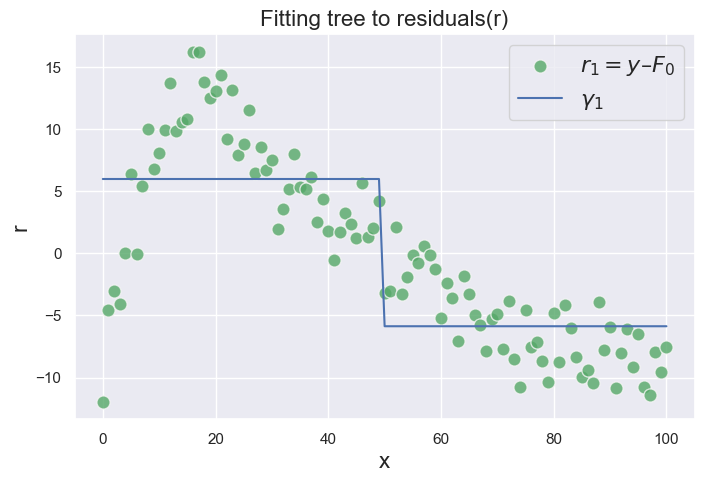

--------------------------------------------------------------------------------
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 49.5 else to node 2.
	node=1 is a leaf node.
	 prediction: 6.0
	node=2 is a leaf node.
	 prediction: -5.9
--------------------------------------------------------------------------------


In [14]:
tree, Fm, gamma, r = train_and_update(x, y, F0, learing_rate=0.9)
    
fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 1, ax, "Fitting tree to residuals(r)")
plt.show()
print_tree(tree)

- In this example, we use a relatively big learning rate ν = 0.9 to make the optimization process easier to understand, but it is usually supposed to be a much smaller value such as 0.1.
- The new prediction is shown below:

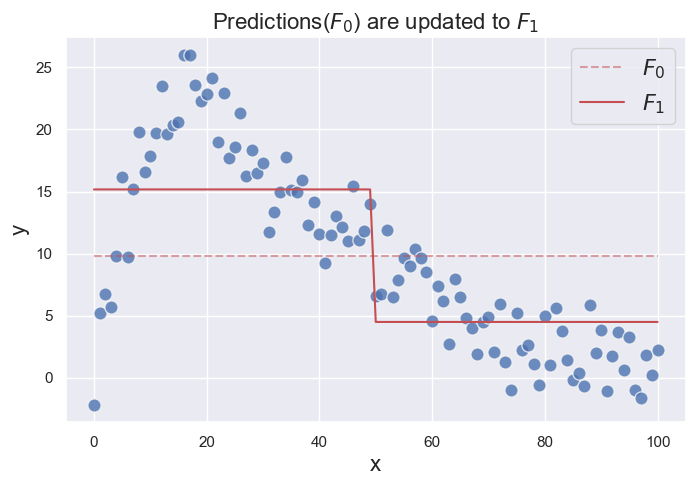

In [15]:
def plot_update(x, y, Fm, Fm_pre, i):
    
    plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    plt.plot(x, Fm_pre, c='r', linestyle='--', label=f'$F_{i-1}$', alpha=0.5)
    plt.plot(x, Fm, c='r', label=f'$F_{i}$')
    plt.title(f"Predictions($F_{i-1}$) are updated to $F_{i}$", fontsize=16)
    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)
    plt.legend(fontsize=16)
    plt.show()
    
plot_update(x, y, Fm, F0, 1)

- Now, we repeat the process: look at new residuals and create new regression tree.

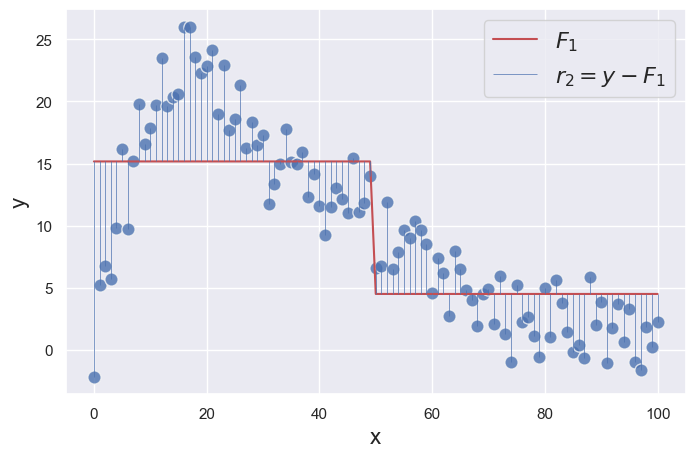

In [16]:
fig, ax = plt.subplots(1, 1)
plot_residuals(x, y, Fm, 1, ax)
plt.show()

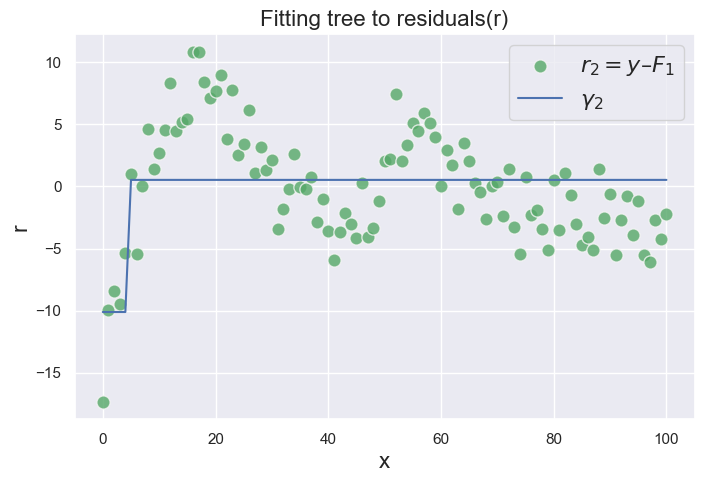

--------------------------------------------------------------------------------
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 4.5 else to node 2.
	node=1 is a leaf node.
	 prediction: -10.1
	node=2 is a leaf node.
	 prediction: 0.5
--------------------------------------------------------------------------------


In [17]:
Fm_pre = Fm.copy()
tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)

fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 2, ax, "Fitting tree to residuals(r)")
plt.show()
print_tree(tree)

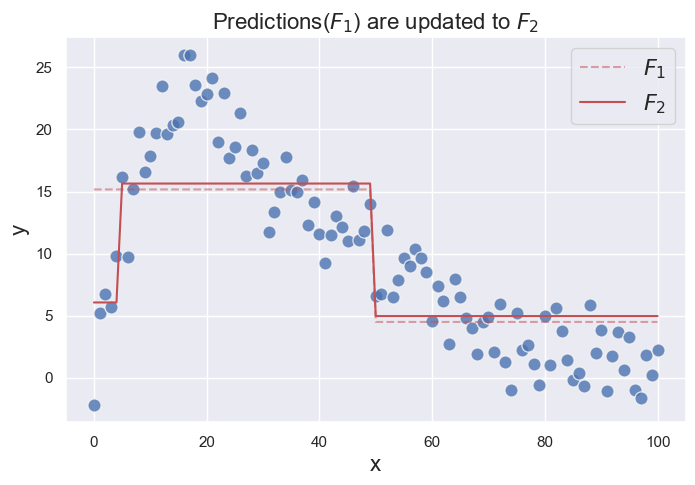

In [18]:
plot_update(x, y, Fm, Fm_pre, 2)

- We iterate these steps until the model prediction stops improving. The figures below show the optimization process from 0 to 6 interactions.

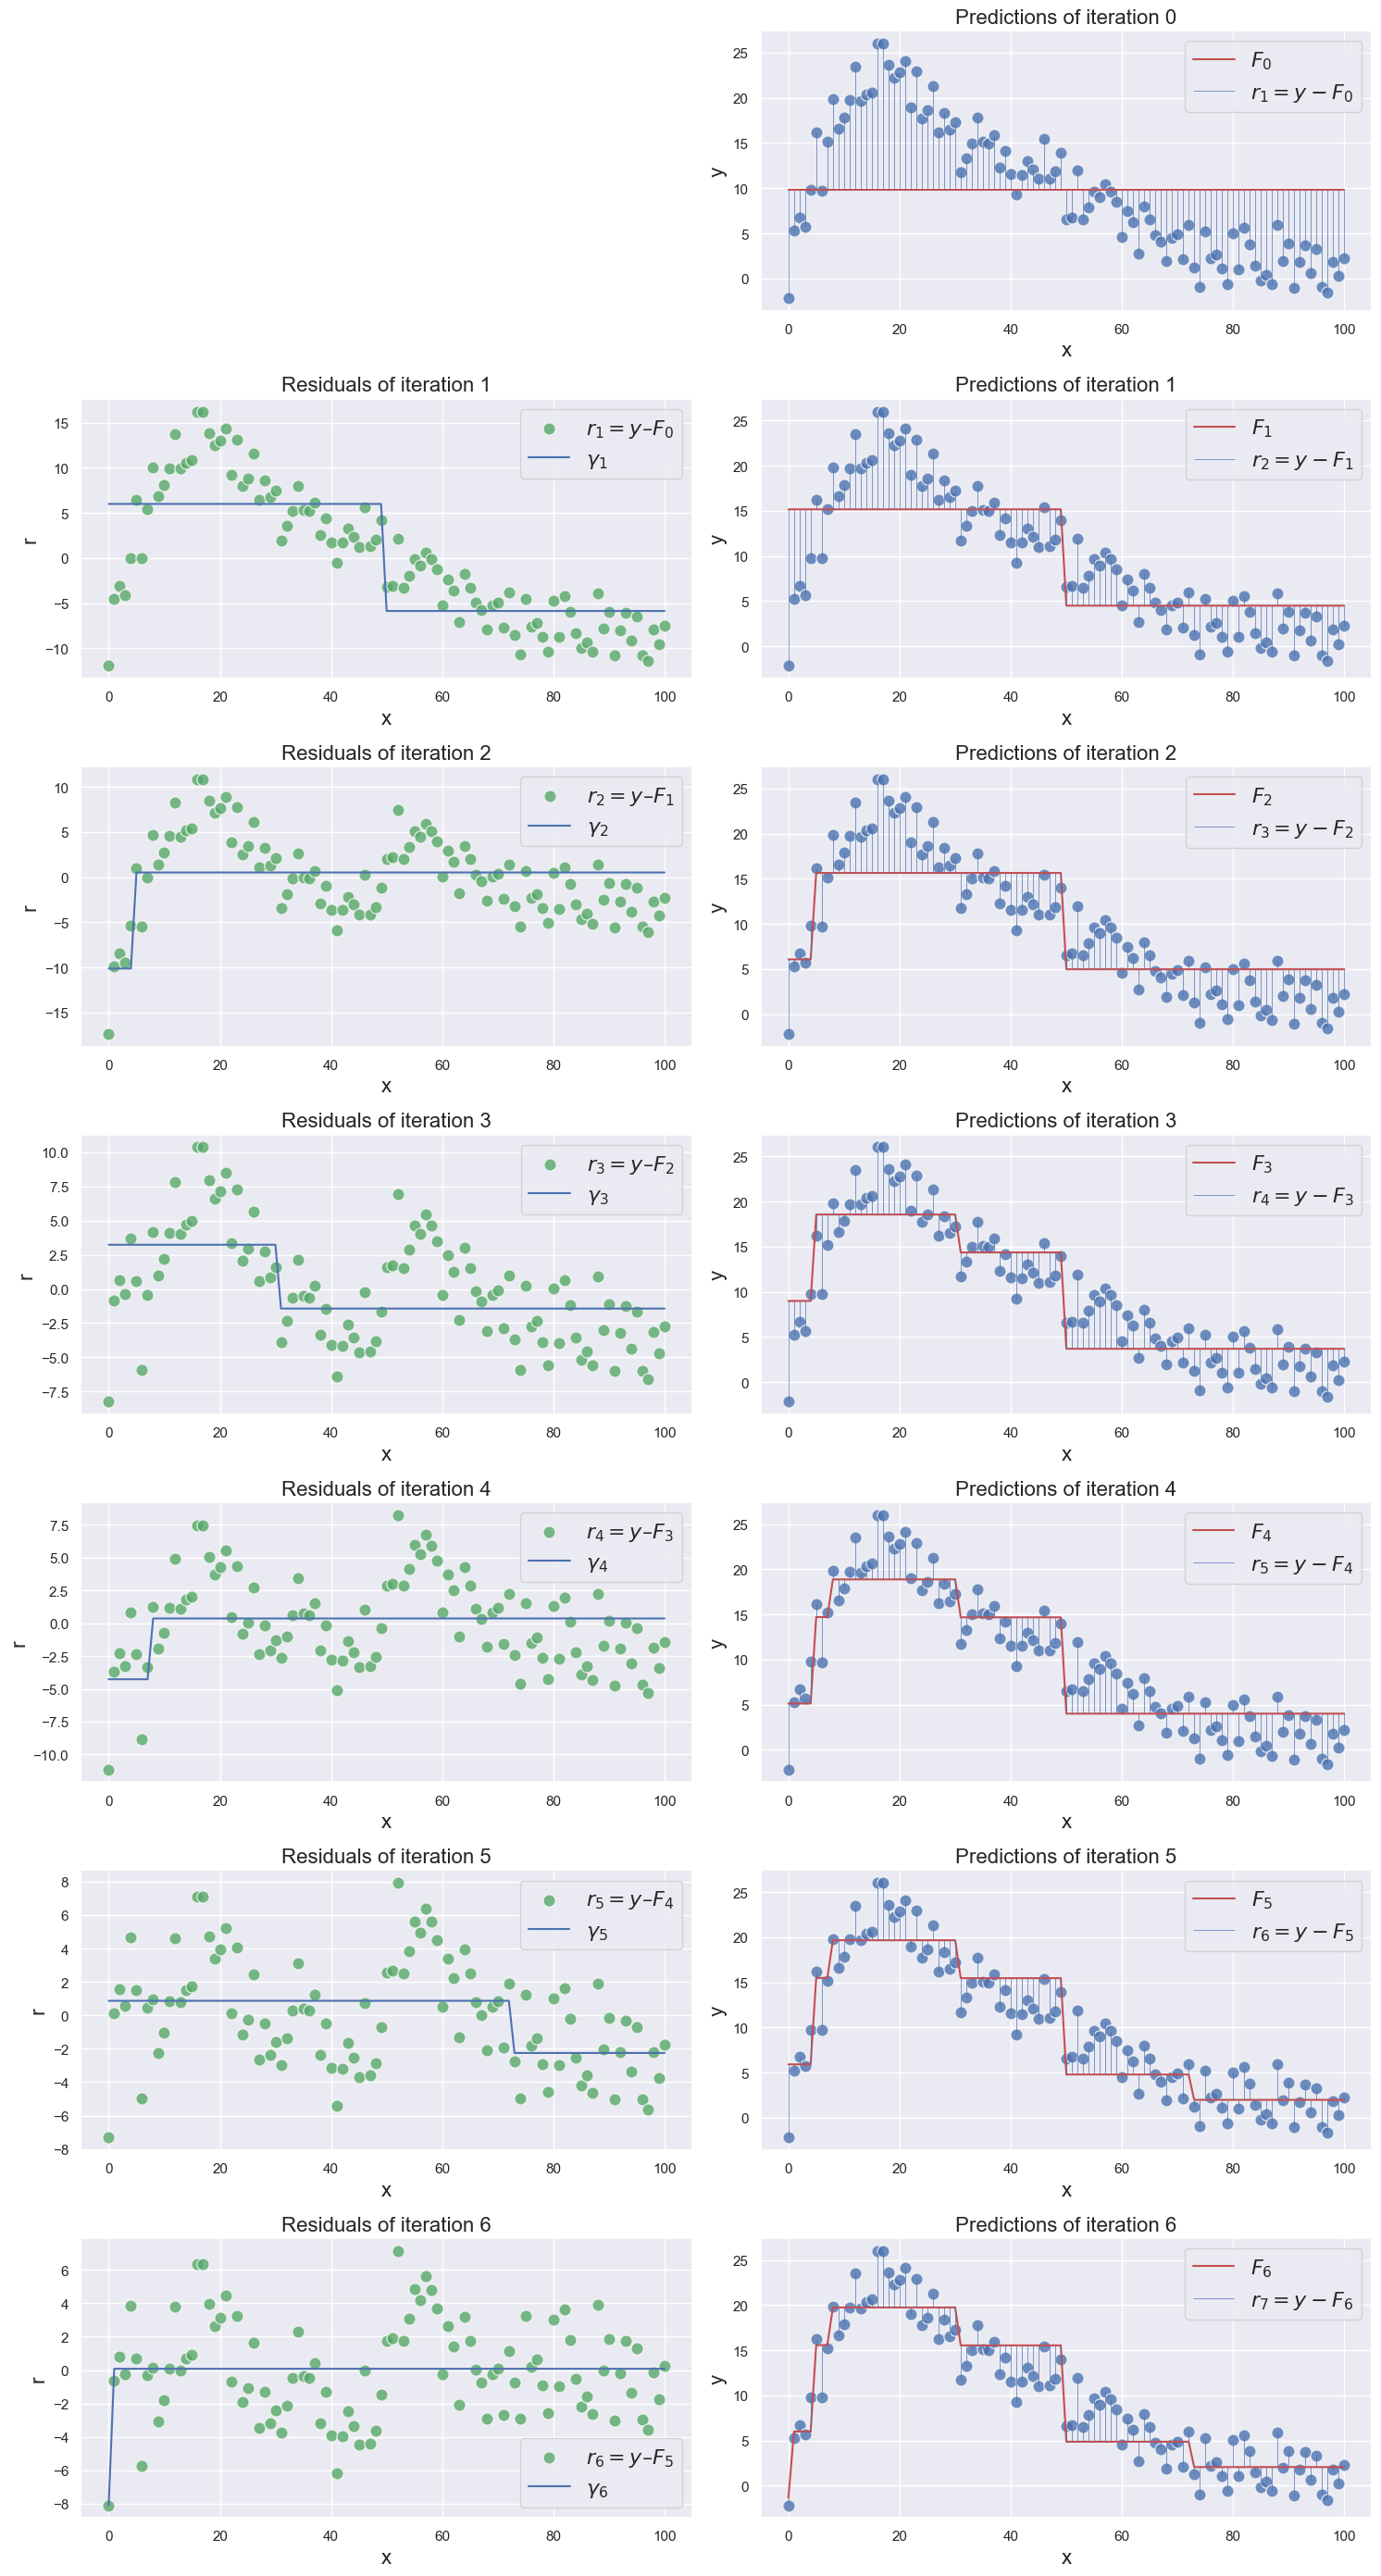

In [19]:
Fm = F0 = np.full(len(y), y.mean())
n_estimators = 6

fig, axs = plt.subplots(n_estimators+1, 2, figsize=(15, 4*(n_estimators+1)))
axs = axs.flatten()
axs[0].axis('off')

plot_residuals(x, y, F0, 0, axs[1], title="Predictions of iteration 0")

for i in range(n_estimators):
    tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)
    
    j = 2 + i*2
    plot_gamma(x, r, gamma, i+1, axs[j], f"Residuals of iteration {i+1}")
    plot_residuals(x, y, Fm, i+1, axs[j+1], title=f"Predictions of iteration {i+1}")
    
plt.tight_layout()
plt.show()

#### An example with ScikitLearn

from sklearn.ensemble import GradientBoostingRegressor

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


gbm = GradientBoostingRegressor(n_estimators=20, learning_rate=0.1, max_depth=1)

gbm.fit(x, y)
gbm_rmse = mean_squared_error(y, gbm.predict(x), squared=False)
print(f"Scikit-learn GBM RMSE:{gbm_rmse:.15f}")

Scikit-learn GBM RMSE:3.961707263264281


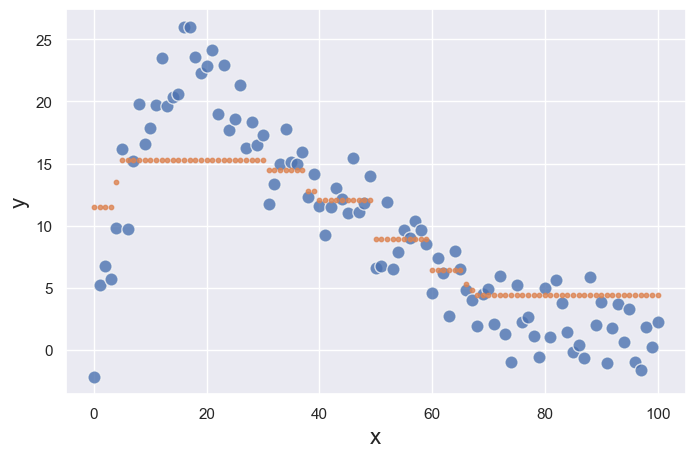

In [25]:
y_pred = gbm.predict(x)

plt.rcParams["figure.figsize"] = (8, 5)
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.scatter(x, y_pred, s=10, alpha=0.8)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

- Of course, this can be improved by changing the parameters of the model. Here we were only using STUMPS!

In [30]:
gbm = GradientBoostingRegressor(learning_rate=0.1, max_depth= 3)

gbm.fit(x, y)
gbm_rmse = mean_squared_error(y, gbm.predict(x), squared=False)
print(f"Scikit-learn GBM RMSE:{gbm_rmse:.15f}")

Scikit-learn GBM RMSE:1.035707877959650


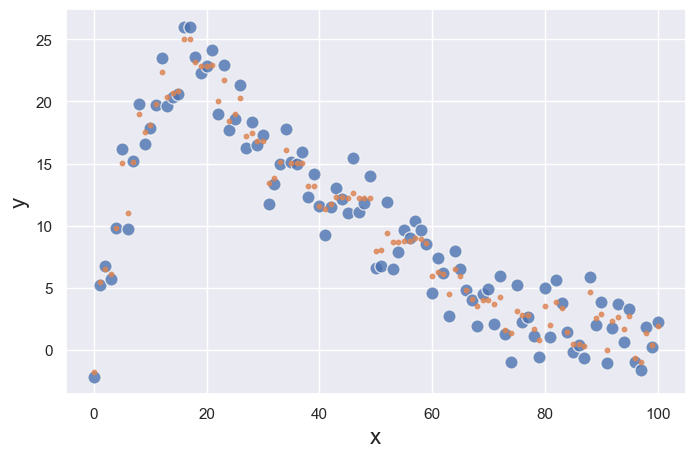

In [31]:
y_pred = gbm.predict(x)

plt.rcParams["figure.figsize"] = (8, 5)
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.scatter(x, y_pred, s=10, alpha=0.8)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

- As usual, one would need to split the data into training and testing data and perform a cross-validation/grid search to find the optimal parameters.

### Avoiding Overfitting in Gradient Boost

- To avoid overfitting, we will run a grid search and combine it with cross-validation. Let us use a k=5-fold cross validation for the 100 data points.
- We can do a grid search for some of the parameters of the Gradient Boost:
    1. n_estimators
    2. learning_rate
    3. max_depth


In [33]:
x.shape

(101, 1)

In [44]:
model = GradientBoostingRegressor() #learning_rate=0.1, max_depth= 3

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [5, 10, 15, 20, 25]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['max_depth'] = [1, 2, 3, 4, 5]


# define the grid search procedure
# cv stands for cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring = 'neg_mean_squared_error')

# execute the grid search
grid_result = grid_search.fit(x, y)

In [45]:
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -18.724840 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 15}


In [46]:
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-78.023451 (41.480097) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 5}
-77.973060 (41.461941) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 10}
-77.922719 (41.443796) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 15}
-77.872427 (41.425661) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 20}
-77.822185 (41.407537) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 25}
-78.005124 (41.469412) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 5}
-77.936432 (41.440586) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 10}
-77.867816 (41.411786) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 15}
-77.799277 (41.383013) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 20}
-77.730814 (41.354267) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 25}
-78.002053 (41.460067) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 5}
-7

- Fit with the best model:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=45) 

gbm = GradientBoostingRegressor(learning_rate=0.1, max_depth= 2, n_estimators = 15)
gbm.fit(X_train, y_train)

gbm_rmse = mean_squared_error(y_test, gbm.predict(X_test), squared=False)
print(f"Scikit-learn GBM RMSE:{gbm_rmse:.15f}")

Scikit-learn GBM RMSE:4.099803115316920


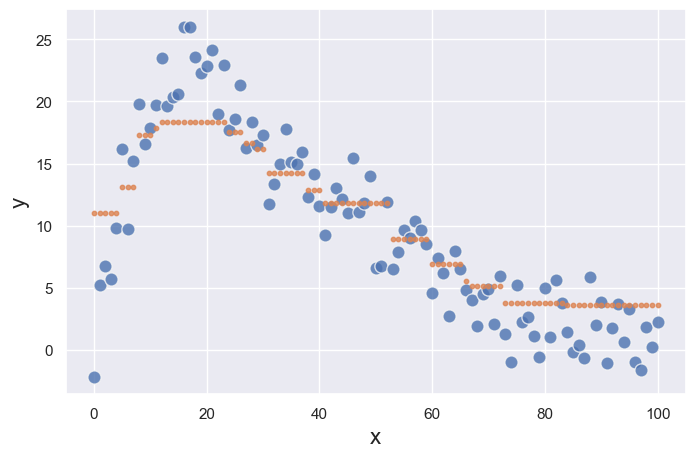

In [50]:
y_pred = gbm.predict(x)

plt.rcParams["figure.figsize"] = (8, 5)
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.scatter(x, y_pred, s=10, alpha=0.8)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

### <font color='green'>Gradient Boost for Classification</font>

#### An example

See: https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-2-classification-d3ed8f56541e